In [21]:
# BASE CODE

import simpy
import numpy as np
import matplotlib.pyplot as plt

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Confidence Interval calculation
from scipy.stats import t
def confidence_interval(simulation_results, title="", confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    std = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print(str(title) + str(mean))
        conf_int_low = mean-std
        conf_int_high = mean+std
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval's Size: ", conf_int_high-conf_int_low)
    return mean, std

def visualize_conf_interval(labels, means, std, title, xlabel, ylabel):
    lower = np.subtract(means, std)
    upper = np.add(means, std)

    plt.figure(figsize=(12, 8))
    plt.plot(means,'-b', label='Mean')
    plt.plot(upper,'-r', label='Upper Boundary of CI')
    plt.plot(lower,'-g', label='Lower Boundary of CI')
    plt.fill_between(list(range(len(means))), upper, lower, color="k", alpha=0.15)
    default_x_ticks = range(len(labels))
    plt.xticks(default_x_ticks, labels)
    plt.ylim(0, 20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    return

def visualize_line(labels, values, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    plt.plot(values,'-b')
    default_x_ticks = range(len(labels))
    plt.xticks(default_x_ticks, ['%.1f' % i for i in labels])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return

# Supports arrays
def box_plot(data, title, x_axis, x_axis_ticks, y_axis):
    fig, ax = plt.subplots(figsize =(12, 8))
    ax.boxplot(data)
    ax.set_xticklabels(x_axis_ticks)
    fig.suptitle(title, fontsize=20)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel(y_axis, fontsize=16)
    plt.show()

# Class that handles creation of Jobs
def Source(env, jobs_to_process, arrival_rate, resources):
    for i in range(jobs_to_process):
        c = Customer(env, 'Customer ' + str(i), resources)
        env.process(c)
        t = np.random.exponential(1/arrival_rate)
        yield env.timeout(t)

# Class that handles everything else related to Queues
def Customer(env, name, resources):
    arrive = env.now

    # Deciding on job size
    if job_distribution=="Exponential":
        job_duration = np.random.exponential(1/job_rate)
    if job_distribution=="Exponential_Fat":
        if np.random.uniform() < 0.75:
            job_duration = np.random.exponential(1/job_rate)
        else:
            job_duration = np.random.exponential(1/(5*job_rate))
    if job_distribution=="Degenerate":
            job_duration = 1/job_rate

    job_durations.append(job_duration)
    # Handling depends on the chosen queue
    if priority_queue:
        # Sending job to its position
        with resources.request(priority=job_duration) as req:
            # Wait for the Server
            yield req
            waiting_times.append(env.now - arrive)
            # Starting the Job
            yield env.timeout(job_duration)
    else:
        with resources.request() as req:
            # Wait for the Server
            yield req
            waiting_times.append(env.now - arrive)
            # Starting the Job
            yield env.timeout(job_duration)


# Params
jobs_to_process = 10_000    # Number of Jobs
runtime_limit = 500.0       # Runtime Limit

arrival_rate = 12.0     # lambda, where mean of distr is given by 1/lambda
job_rate = 1.0          # miu, where mean of distr is given by 1/miu
servers_amount = 8      # n

priority_queue = False
job_distribution = "Exponential"    # "Exponential", "Exponential_Fat", "Degenerate"

waiting_times = []      # Waiting times of performed jobs
job_durations = []      # Average job size


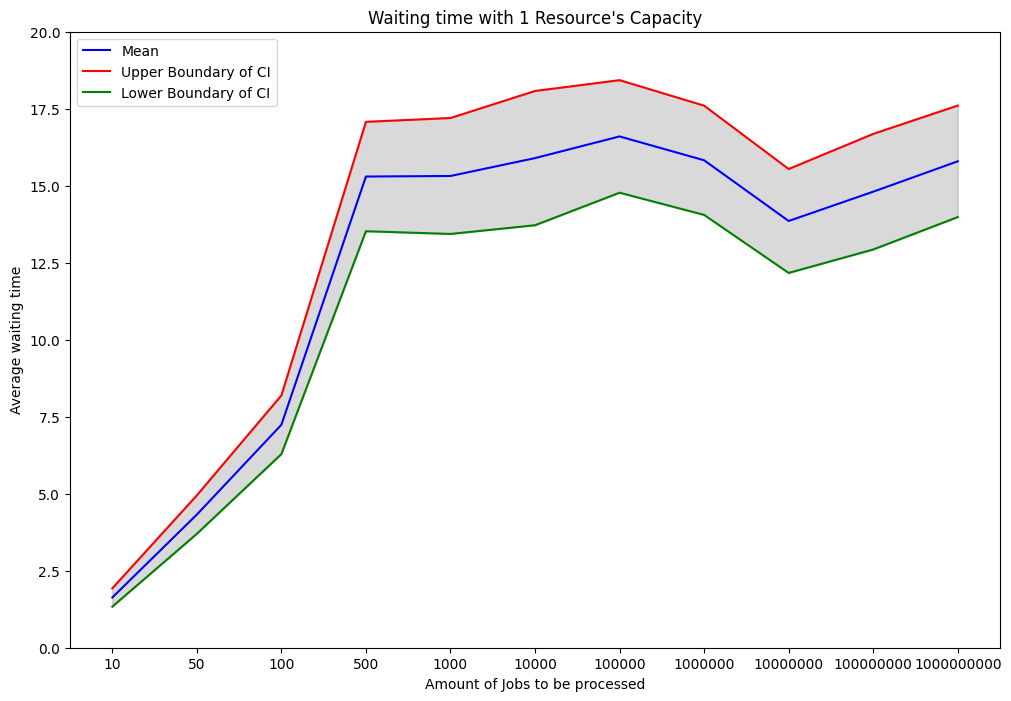

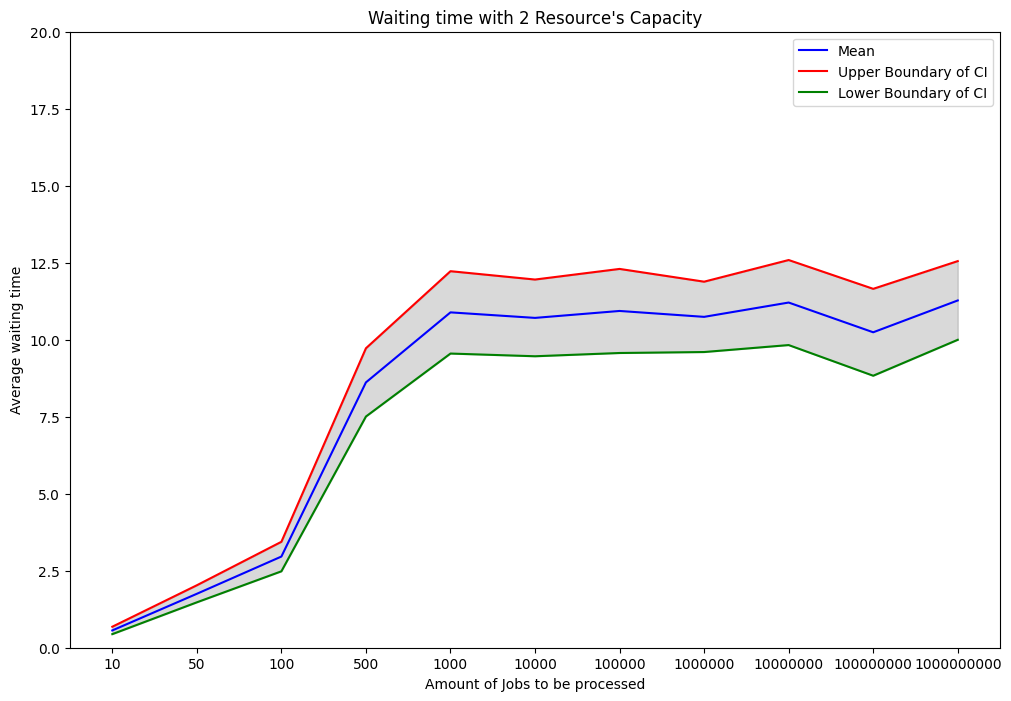

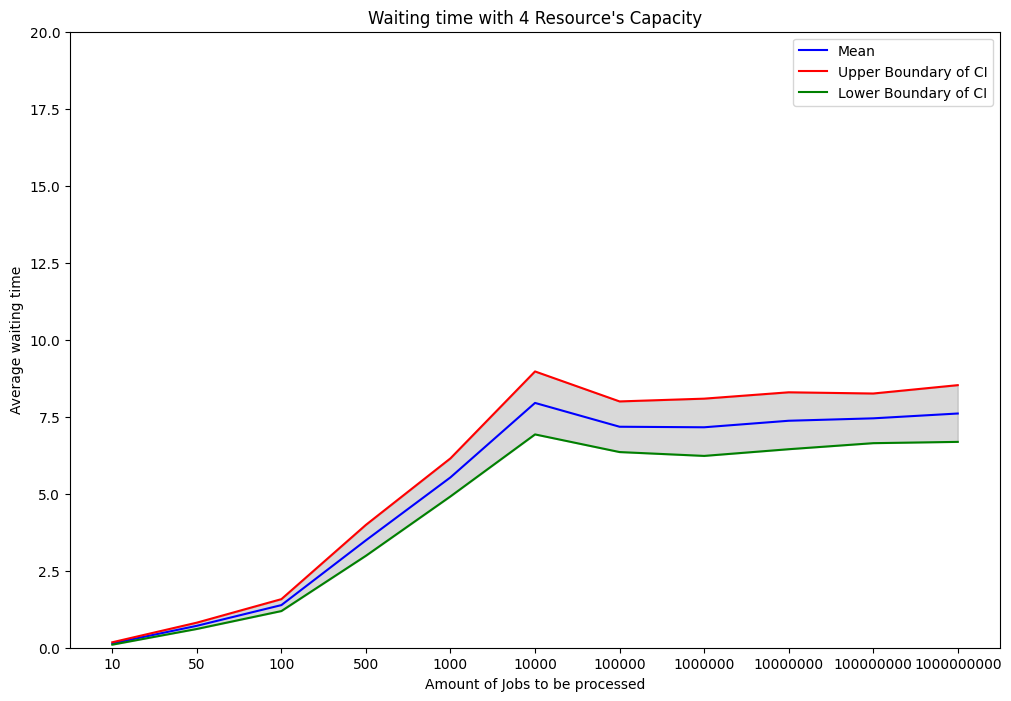

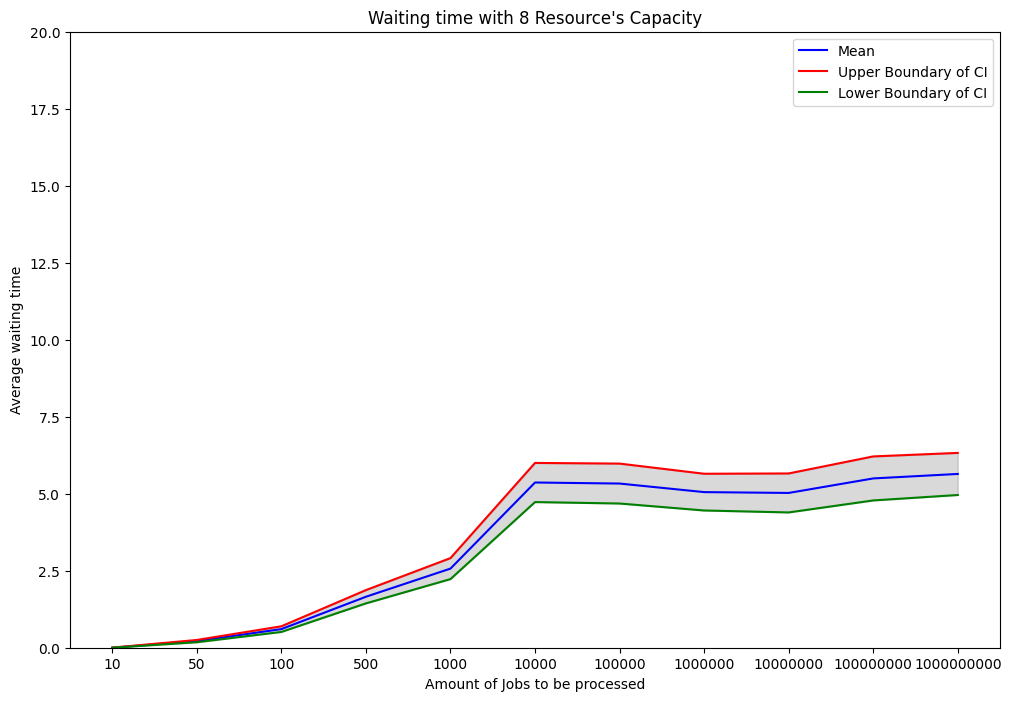

In [22]:
# Deciding on amount of Jobs to Process

runtime_limit = 500.0   # Runtime Limit
job_distribution = "Exponential"    # "Exponential", "Exponential_Fat", "Degenerate"
priority_queue = False

seed = 42                   # Seed for Simulation
np.random.seed(seed)

servers_amount_arr = [1, 2, 4, 8]
for servers_amount in servers_amount_arr:

    # Balancing these parameters so that rho is close to 1
    arrival_rate = servers_amount * 1.0 - 0.001             # lambda
    job_rate = 1.0                                          # miu
    system_load = arrival_rate/(servers_amount * job_rate)  #rho
    
    # Starting Simulation
    trials = 100
    waiting_mean = []
    waiting_ci = []
    jobs_to_process_arr = [10, 50, 100, 500, 1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000]
    for jobs_to_process in jobs_to_process_arr:
        waiting_times_trials = []
        for i in range(trials):
            waiting_times = []      # Waiting times of performed jobs
            # Setup trial
            env = simpy.Environment()
            resources = simpy.Resource(env, capacity = servers_amount)

            env.process(Source(env, jobs_to_process, arrival_rate, resources))
            env.run(until=runtime_limit)

            waiting_times_trials.append(np.mean(waiting_times))

        mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
        waiting_mean.append(mean)
        waiting_ci.append(std)

    visualize_conf_interval(jobs_to_process_arr, waiting_mean, waiting_ci, "Waiting time with " + str(servers_amount) + " Resource's Capacity", "Amount of Jobs to be processed", "Average waiting time")

# As can be seen 10_000 jobs for the queue is an optimal amount, as it is enough fo the queue to stabilize around same value.

Servers: 1, ρ: 0.999
Servers: 2, ρ: 0.9995
Servers: 4, ρ: 0.99975
Servers: 8, ρ: 0.999875
Average job's size is: 0.9999927120595332
With the Confidence Interval:  0.9969645701535731 1.0030208539654932
Confidence Interval's Size:  0.006056283811920138

Average waiting for each amount of servers:  [16.527821840357195, 10.011303173120792, 8.505433942521732, 5.604872753035388]
Confidence Intervals for each amount of servers: ± [2.078644279933572, 1.2151823894684544, 1.1016006797889173, 0.7280886681506615]


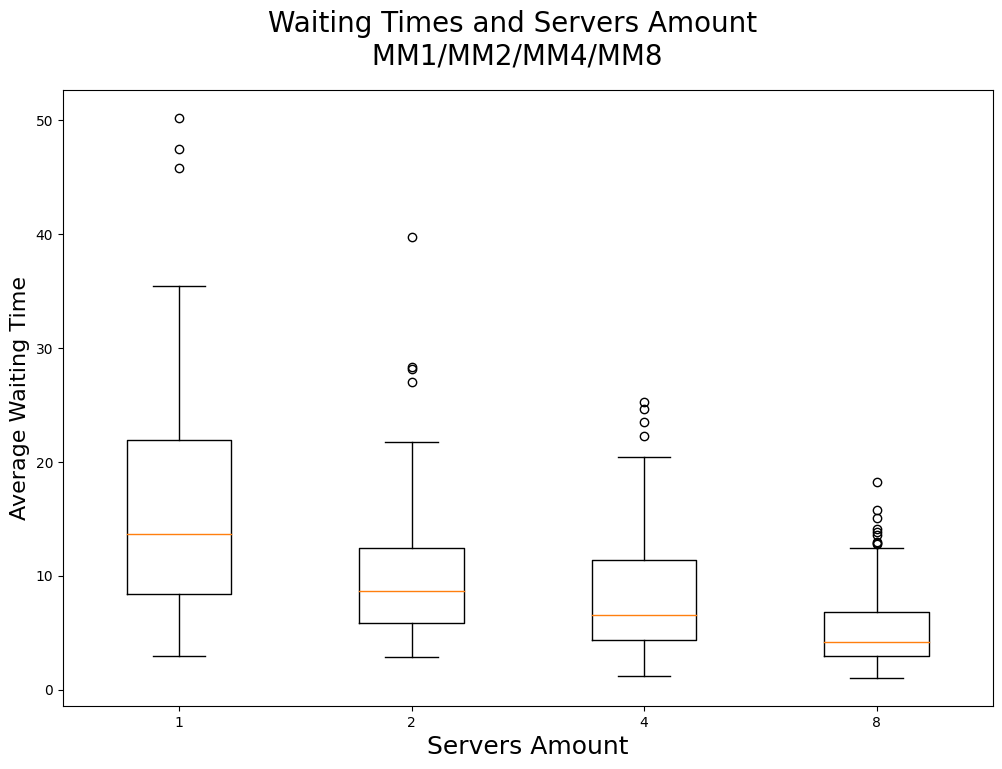

In [23]:
jobs_to_process = 10_000  # Number of Jobs
runtime_limit = 500.0   # Runtime Limit
job_distribution = "Exponential"    # "Exponential", "Exponential_Fat", "Degenerate"
priority_queue = False

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Final Results Params
waiting_times_list = []
waiting_mean = []
waiting_ci = []

job_durations_trials = []
servers_amount_arr = [1, 2, 4, 8]
for servers_amount in servers_amount_arr:

    # Balancing these parameters so that rho is close to 1
    arrival_rate = servers_amount * 1.0 - 0.001             # lambda
    job_rate = 1.0                                          # miu
    system_load = arrival_rate/(servers_amount * job_rate)  #rho
    print("Servers: " + str(servers_amount) + ", ρ: " + str(system_load))
    
    # Starting Simulation
    trials = 100
    waiting_times_trials = []
    for i in range(trials):
        waiting_times = []      # Waiting times of performed jobs
        job_durations = []
        # Setup trial
        env = simpy.Environment()
        resources = simpy.Resource(env, capacity = servers_amount)
        
        env.process(Source(env, jobs_to_process, arrival_rate, resources))
        env.run(until=runtime_limit)

        waiting_times_trials.append(np.mean(waiting_times))     # Saving Results
        job_durations_trials.append(np.mean(job_durations))     # Saving Results


    waiting_times_list.append(waiting_times_trials)
    mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
    waiting_mean.append(mean)
    waiting_ci.append(std)

confidence_interval(job_durations_trials, "Average job's size is: ", output_results=True)    # Just to verify that right distribution is used
print()
print("Average waiting for each amount of servers: ", waiting_mean)
print("Confidence Intervals for each amount of servers: \u00B1", waiting_ci)
# Visualization
#visualize_conf_interval(servers_amount_arr, waiting_mean, waiting_ci, "Waiting time and Servers Amount", "Servers Amount", "Average waiting time")
box_plot(waiting_times_list, "Waiting Times and Servers Amount\n MM1/MM2/MM4/MM8", "Servers Amount", servers_amount_arr, "Average Waiting Time")

Average waiting for each ρ:  [0.011305459904647288, 0.039603642246409006, 0.09717211804439362, 0.17746176839914135, 0.30694867485115174, 0.5812586135653348, 0.9475016894300228, 1.6724968778286515, 3.903082002741729, 10.844316020250881, 27.53870522280713, 42.068208332637475, 58.70138445640677, 70.931157598443, 84.27964611550337, 93.86218279978182, 102.72195105527251, 108.78864649151525, 116.7964957207978, 123.30294354869793, 131.11251091581508, 135.27070213128383, 140.46564089643778, 144.7169908654904, 150.71397580973516]

Confidence Intervals for each ρ: ± [0.002838013729640188, 0.0047048690989205996, 0.008092704707905393, 0.010350468683953161, 0.01917895627770867, 0.0377944495820528, 0.06654404461691757, 0.14759081150810435, 0.41556178596244137, 1.4649440174256125, 1.8433509612909333, 2.065829613509205, 2.0512676912407843, 1.8115003387245774, 1.8173822007004883, 1.732152719388641, 1.40041954514054, 1.5744314875655356, 1.4148627769930682, 1.6572848978502843, 1.3925369813419253, 1.36828

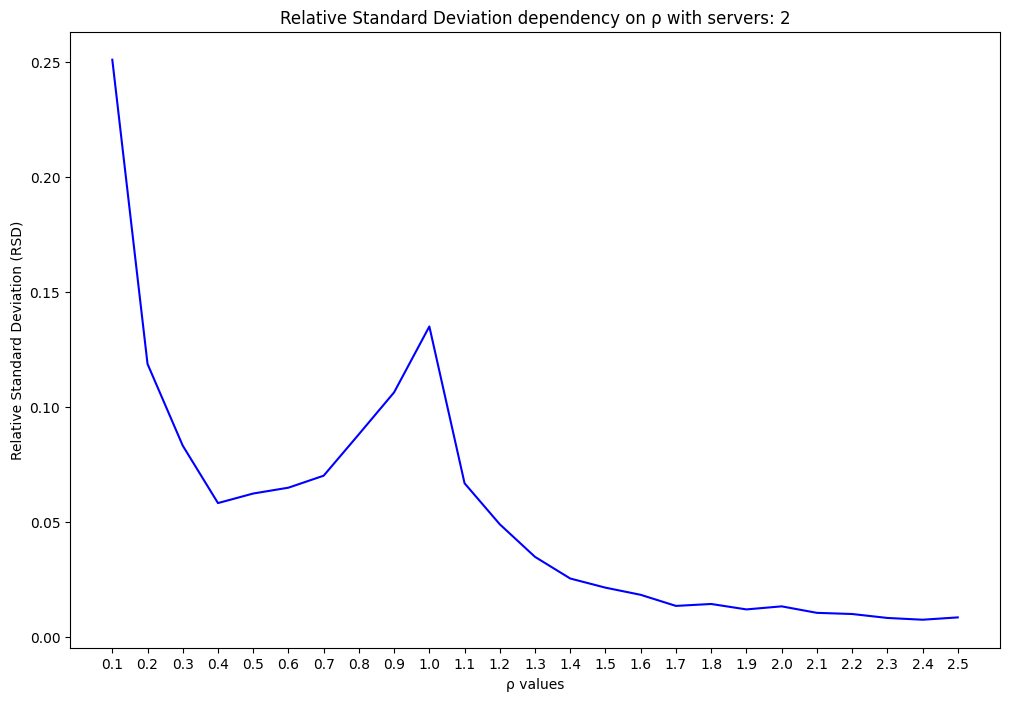

In [24]:
jobs_to_process = 10_000    # Number of Jobs
runtime_limit = 500.0       # Runtime Limit
job_distribution = "Exponential"    # "Exponential", "Exponential_Fat", "Degenerate"
priority_queue = False

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Final Results Params
waiting_times_list = []
waiting_mean = []
waiting_ci = []

# Balancing these parameters so that rho is close to 1
servers_amount = 2  # n
job_rate = 1.0      # miu
system_load_arr = []
arrival_rates_list = np.arange(0.1, 2.6, 0.1)
arrival_rates_list = [x * servers_amount for x in arrival_rates_list]
for arrival_rate in arrival_rates_list:   # varying lambda
    system_load_arr.append(arrival_rate/(servers_amount * job_rate))  #rho

    # Starting Simulation
    trials = 100
    waiting_times_trials = []
    for i in range(trials):
        waiting_times = []      # Waiting times of performed jobs
        # Setup trial
        env = simpy.Environment()
        # Creating Queues
        if priority_queue:
            resources = simpy.PriorityResource(env, capacity = servers_amount)
        else:
            resources = simpy.Resource(env, capacity = servers_amount)
        env.process(Source(env, jobs_to_process, arrival_rate, resources))
        env.run(until=runtime_limit)

        waiting_times_trials.append(np.mean(waiting_times))     # Saving Results

    waiting_times_list.append(waiting_times_trials)
    mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
    waiting_mean.append(mean)
    waiting_ci.append(std)

print("Average waiting for each ρ: ", waiting_mean)
print()
print("Confidence Intervals for each ρ: \u00B1", waiting_ci)
# Visualization Relative Standard Deviation (RSD)
visualize_line(system_load_arr, np.divide(waiting_ci, waiting_mean), "Relative Standard Deviation dependency on ρ with servers: " + str(servers_amount), "ρ values", "Relative Standard Deviation (RSD)")
#box_plot(waiting_times_list, "Confidence interval dependency on ρ", "ρ values", arrival_rates_list, "Waiting Times")

Average waiting without and with Priority Queue:  [11.17648162450734, 2.468229037380058]
Confidence Intervals without and with Priority Queue: ± [1.3353192509247775, 0.15438814870213322]


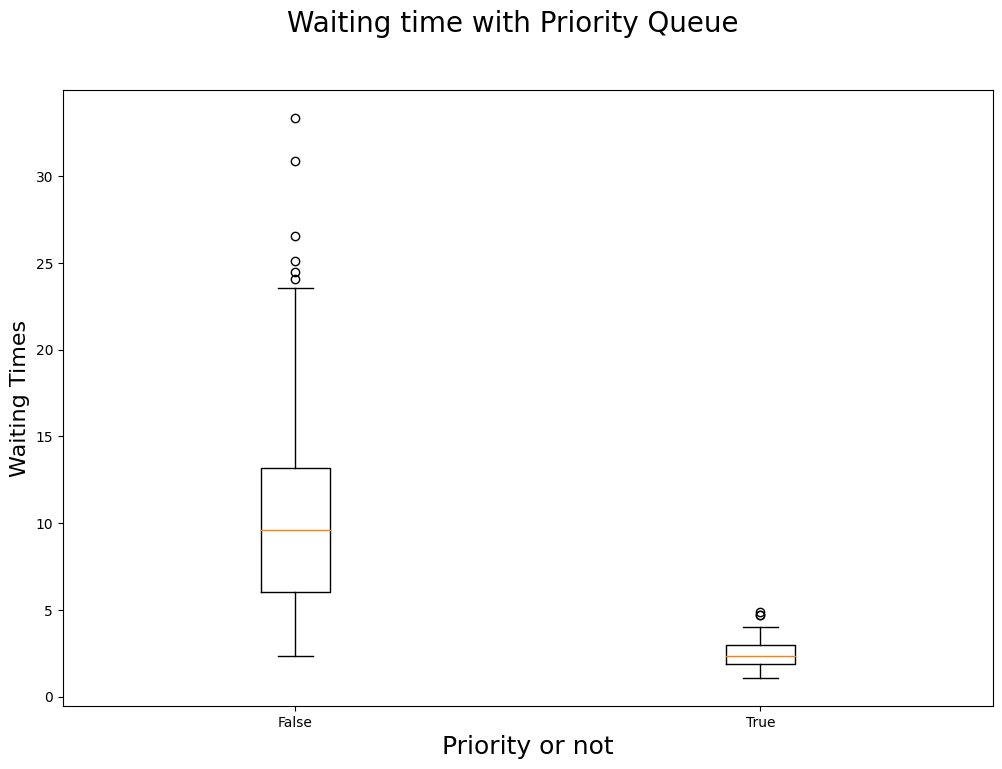

In [25]:
jobs_to_process = 10_000    # Number of Jobs
runtime_limit = 500.0   # Runtime Limit
job_distribution = "Exponential"    # "Exponential", "Exponential_Fat", "Degenerate"

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Final Results Params
waiting_times_list = []
waiting_mean = []
waiting_ci = []

# Balancing these parameters so that rho is close to 1
servers_amount = 2                                      #n
arrival_rate = servers_amount * 1.0 - 0.001             # lambda
job_rate = 1.0                                          # miu
system_load = arrival_rate/(servers_amount * job_rate)  #rho

priority_queue_arr = [False, True]
for priority_queue in priority_queue_arr:

    # Starting Simulation
    trials = 100
    waiting_times_trials = []
    for i in range(trials):
        waiting_times = []      # Waiting times of performed jobs
        # Setup trial
        env = simpy.Environment()
        # Creating Queues
        if priority_queue:
            resources = simpy.PriorityResource(env, capacity = servers_amount)
        else:
            resources = simpy.Resource(env, capacity = servers_amount)
        env.process(Source(env, jobs_to_process, arrival_rate, resources))
        env.run(until=runtime_limit)

        waiting_times_trials.append(np.mean(waiting_times))

    waiting_times_list.append(waiting_times_trials)
    mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
    waiting_mean.append(mean)
    waiting_ci.append(std)

print("Average waiting without and with Priority Queue: ", waiting_mean)
print("Confidence Intervals without and with Priority Queue: \u00B1", waiting_ci)
#visualize_conf_interval(priority_queue_arr, waiting_mean, waiting_ci, "Waiting time with Priority Queue:" + str(priority_queue) + ". " + " Resource's Capacity", "Amount of Jobs to be processed", "Average waiting time")
box_plot(waiting_times_list, "Waiting time with Priority Queue", "Priority or not", priority_queue_arr, "Waiting Times")

Servers: 1, ρ: 0.999
Servers: 2, ρ: 0.9995
Servers: 4, ρ: 0.99975
Servers: 8, ρ: 0.999875
Average job's size is: 1.0
With the Confidence Interval:  1.0 1.0
Confidence Interval's Size:  0.0

Average waiting for each amount of servers:  [11.796482479348619, 7.439251648435969, 5.514535754160804, 3.8311620011063847]
Confidence Intervals for each amount of servers: ± [1.3116933743506136, 0.9148234233575117, 0.6046079742329169, 0.449211139499876]


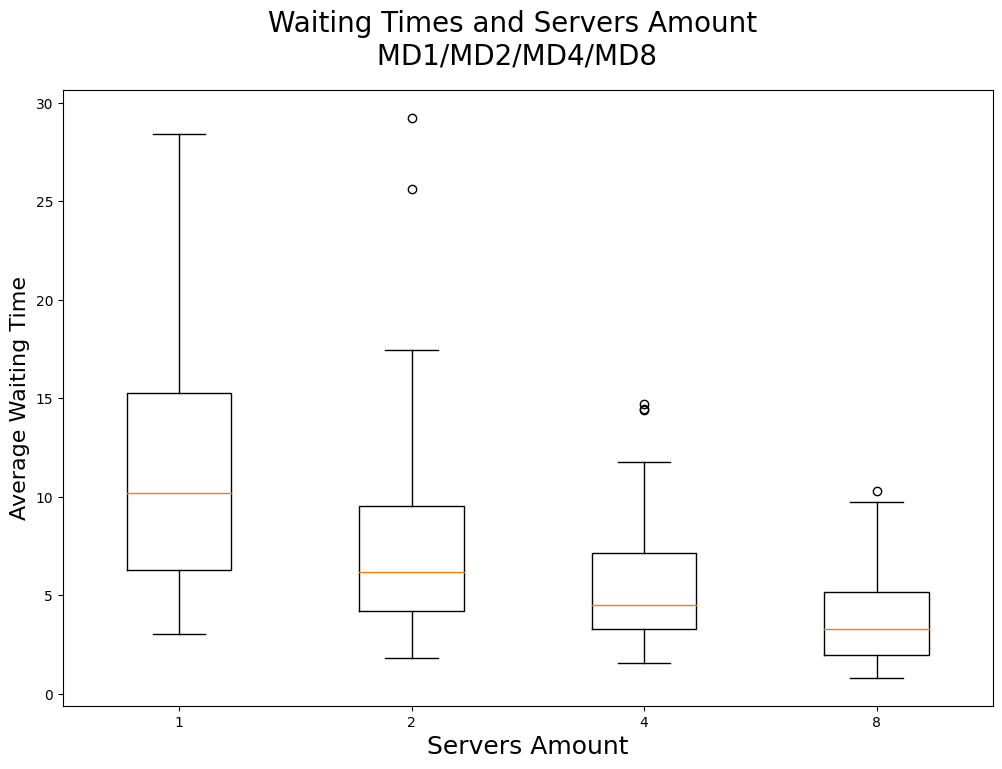

In [26]:
jobs_to_process = 10_000  # Number of Jobs
runtime_limit = 500.0   # Runtime Limit
job_distribution = "Degenerate"    # "Exponential", "Exponential_Fat", "Degenerate"
priority_queue = False

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Final Results Params
job_durations_trials = []
waiting_times_list = []
waiting_mean = []
waiting_ci = []

servers_amount_arr = [1, 2, 4, 8]
for servers_amount in servers_amount_arr:

    # Balancing these parameters so that rho is close to 1
    arrival_rate = servers_amount * 1.0 - 0.001             # lambda
    job_rate = 1.0                                          # miu
    system_load = arrival_rate/(servers_amount * job_rate)  #rho
    print("Servers: " + str(servers_amount) + ", ρ: " + str(system_load))
    
    # Starting Simulation
    trials = 100
    waiting_times_trials = []

    for i in range(trials):
        waiting_times = []      # Waiting times of performed jobs
        job_durations = []
        # Setup trial
        env = simpy.Environment()
        resources = simpy.Resource(env, capacity = servers_amount)
        
        env.process(Source(env, jobs_to_process, arrival_rate, resources))
        env.run(until=runtime_limit)

        waiting_times_trials.append(np.mean(waiting_times))     # Saving Results
        job_durations_trials.append(np.mean(job_durations))     # Saving Results

    waiting_times_list.append(waiting_times_trials)
    mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
    waiting_mean.append(mean)
    waiting_ci.append(std)

confidence_interval(job_durations_trials, "Average job's size is: ", output_results=True)    # Just to verify that right distribution is used
print()
print("Average waiting for each amount of servers: ", waiting_mean)
print("Confidence Intervals for each amount of servers: \u00B1", waiting_ci)
# Visualization
#visualize_conf_interval(servers_amount_arr, waiting_mean, waiting_ci, "Waiting time and Servers Amount", "Servers Amount", "Average waiting time")
box_plot(waiting_times_list, "Waiting Times and Servers Amount\n MD1/MD2/MD4/MD8", "Servers Amount", servers_amount_arr, "Average Waiting Time")

Servers: 1, ρ: 0.9983579410371319
Servers: 2, ρ: 0.9988576196862997
Servers: 4, ρ: 0.9991074590108835
Servers: 8, ρ: 0.9992323786731754
Average job's size is: 1.0235103984187015
With the Confidence Interval:  0.9663040028840127 1.0807167939533904
Confidence Interval's Size:  0.11441279106937763

Average waiting for each amount of servers:  [19.660596320689898, 15.097315060857184, 11.529742695256996, 9.329817896792187]
Confidence Intervals for each amount of servers: ± [2.5783923399471225, 1.7347951746404537, 1.2423247201582712, 0.8588889132709854]


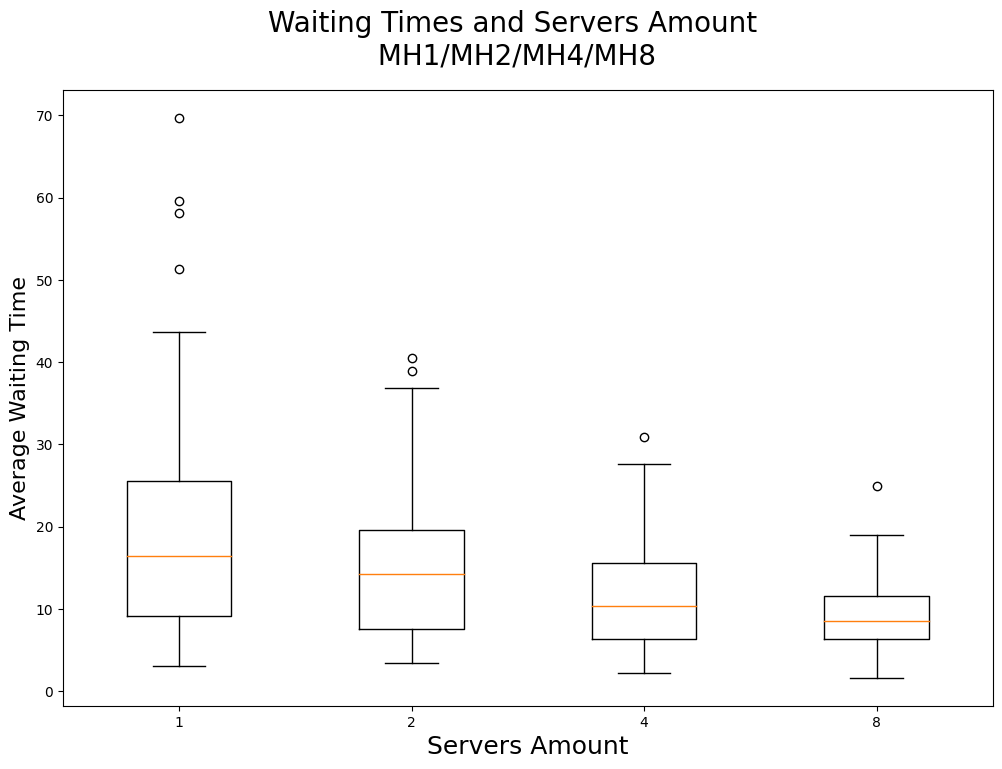

In [27]:
jobs_to_process = 10_000  # Number of Jobs
runtime_limit = 500.0   # Runtime Limit
job_distribution = "Exponential_Fat"    # "Exponential", "Exponential_Fat", "Degenerate"
priority_queue = False

seed = 42                   # Seed for Simulation
np.random.seed(seed)

# Final Results Params
waiting_times_list = []
job_durations_list = []
waiting_mean = []
waiting_ci = []

servers_amount_arr = [1, 2, 4, 8]
for servers_amount in servers_amount_arr:

    # Balancing these parameters so that rho is close to 1
    arrival_rate = servers_amount * 1.0 - 0.001             # lambda
    job_rate = 0.78 + 0.001                                         # miu
    # ρ should be modified, because we changed the underlying distribution for jobs' duration
    # We will express it with expected value, where E(x)=1/μ, thus ρ=λ*E(x)/n
    system_load = (arrival_rate * (0.75*1/job_rate+0.25*1/5*job_rate)) / servers_amount  # rho
    print("Servers: " + str(servers_amount) + ", ρ: " + str(system_load))
    
    # Starting Simulation
    trials = 100
    waiting_times_trials = []
    job_durations_trials = []

    for i in range(trials):
        waiting_times = []      # Waiting times of performed jobs
        job_durations = []
        # Setup trial
        env = simpy.Environment()
        resources = simpy.Resource(env, capacity = servers_amount)
        
        env.process(Source(env, jobs_to_process, arrival_rate, resources))
        env.run(until=runtime_limit)

        waiting_times_trials.append(np.mean(waiting_times))     # Saving Results
        job_durations_trials.append(np.mean(job_durations))     # Saving Results

    waiting_times_list.append(waiting_times_trials)
    job_durations_list.append(job_durations_trials)
    mean, std = confidence_interval(waiting_times_trials, "Average waiting time is: ", output_results=False)
    waiting_mean.append(mean)
    waiting_ci.append(std)

confidence_interval(job_durations_list, "Average job's size is: ", output_results=True)    # Just to verify that right distribution is used
print()
print("Average waiting for each amount of servers: ", waiting_mean)
print("Confidence Intervals for each amount of servers: \u00B1", waiting_ci)
# Visualization
#visualize_conf_interval(servers_amount_arr, waiting_mean, waiting_ci, "Waiting time and Servers Amount", "Servers Amount", "Average waiting time")
box_plot(waiting_times_list, "Waiting Times and Servers Amount\n MΗ1/MΗ2/MΗ4/MΗ8", "Servers Amount", servers_amount_arr, "Average Waiting Time")